# BE 240 Lecture : 2

## Local Sensitivity Analysis
### _Ayush Pandey_



# General nonlinear system dynamics:
\begin{align}
\dot{x} &= f(x, \Theta) + g(x, \Theta)u\\
\dot{y} &= h(x, \Theta)\\
\end{align}
Or in a simpler case: 
\begin{align}
y = Cx\\
\end{align}

where $x$ : States, $\Theta$ : Parameter set, and $y$ : Output


# Sensitivity coefficients:
\begin{align}
S_i(t) = \frac{dx}{d\theta}(t)
\end{align}
where $x$ : State, $\theta$ : Parameter


# Jacobian:
\begin{align}
J = \frac{df}{dx}
\end{align}
where $x$ : State, $f$ : System ODE




# Sensitivity to Parameter:
\begin{align}
Z = \frac{df}{d\theta}
\end{align}
where $x$ : State, $f$ : System ODE

# Fourth-Order Central Difference Method:
We can approximate the derivatives using the fourth order central difference method. This speeds up the computations.
The formula is given by:
\begin{align}
\frac{df}{dx} \approx \frac{-f(x + 2h) + 8f(x+h) - 8f(x-h) + f(x-2h)}{12h}\\
\\
\end{align}

In [1]:
# Compute Jacobian
import warnings
def compute_J(fun, x, params_values, **kwargs):
    '''
    Compute the Jacobian J = df/dx at a point x.
    Returns a matrix of size n x n.
    Uses fourth-order central difference method to compute Jacobian
    '''
    n = len(x)
    var = x
    # initialize J
    J = np.zeros( (n, len(x)) )   
    P = params_values 
    # jfun = nd.Jacobian(lambda x: fun_ode(0, x, P), **kwargs) # Using numdifftools
    # return jfun(x)
    # store the variable with respect to which we approximate the differentiation (df/dvar)
    X = var 
    for i in range(n):
        for j in range(len(var)):
            F = np.zeros( (4,1) )
            h = X[j]*0.01
            # Gets O(4) central difference on dfi/dvarj
            if h != 0:
                var = X
                var[j] = X[j] + 2*h
                f = fun(var, P)
                F[0] = f[i]
                var[j] = X[j] + h
                f = fun(var, P)
                F[1] = f[i]
                var[j] = X[j] - h
                f = fun(var, P)
                F[2] = f[i]
                var[j] = X[j] - 2*h
                f = fun(var, P)
                F[3] = f[i]
                #Store appro var. dfi/dvarj into J
                J[i,j]= (-F[0] + 8*F[1] - 8*F[2] + F[3])/(12*h) 
                # Error check
                if J[i, j] == np.Inf:
                    warnings.warn('Inf found')
                    J[i, j] = 1
                elif J[i, j] == np.NaN:
                    warnings.warn('NaN found')
                    J[i, j] = 0
    return J

In [2]:
def compute_Zj(fun, x, j, params_values, **kwargs):
    '''
    Compute Z_j, i.e. df/dp_j at a particular timepoint k for the parameter p_j. 
    Returns a vector of size n x 1. 
    '''
    n = len(x)
    Z = np.zeros(n)    
    P_holder = params_values
    # For each state
    for i in range(n):
        P = P_holder
        F = np.zeros( (4,1) ) # For 4th order difference
        h = P[j]*0.01 # Small parameter for this parameter
        # Gets O(4) central difference on dfi/dpj
        if h != 0:
            P[j] = P_holder[j] + 2*h
            f = fun(x, P)
            F[0] = f[i]
            P[j] = P_holder[j] + h
            f = fun(x, P)
            F[1] = f[i]
            P[j] = P_holder[j] - h
            f = fun(x, P)
            F[2] = f[i]
            P[j] = P_holder[j] - 2*h
            f = fun(x, P)
            F[3] = f[i]
            #Store approx. dfi/dpj into Z
            Z[i] = (-F[0] + 8*F[1] - 8*F[2] + F[3])/(12*h)   
            if Z[i] == np.Inf:
                warnings.warn('Inf found')
                Z[i] = 1
            elif Z[i] == np.NaN:
                warnings.warn('NaN found')
                Z[i] = 0
    return Z



In [3]:
def compute_SSM(fun, solutions, params_values, timepoints, normalize = False, **kwargs):
    '''
    Returns the sensitivity coefficients S_j for each parameter p_j. 
    Solutions is the ODE solution to fun for timepoints.
    Solutions is of shape (len(timepoints), n), where n is the len(x).
    The sensitivity coefficients are written in a sensitivity matrix SSM of size len(timepoints) x len(params) x n
    If normalize argument is true, the coefficients are normalized by the nominal value of each paramneter.
    '''
    from scipy.integrate import odeint
    def sens_func(t, x, J, Z):
        # forms ODE to solve for sensitivity coefficient S
        dsdt = J@x + Z
        return dsdt
    timepoints_ssm = timepoints
    P = params_values
    S0 = np.zeros(n) # Initial value for S_i  
    SSM = np.zeros( (len(timepoints), len(P), n) )
    xs = solutions
    xs = np.reshape(xs,(len(timepoints), n))
    # Solve for SSM at each time point 
    for k in range(len(timepoints)): 
        timepoints = timepoints_ssm[0:k+1]
        if len(timepoints) == 1:
            continue
        # get the jacobian matrix
#         print(xs[k,:])
        J = compute_J(lambda x, params_values: fun(0, xs[k,:], params_values), xs[k,:], params_values, **kwargs)
#         print(J)
        #Solve for S = dx/dp for all x and all P (or theta, the parameters) at time point k
        for j in range(len(P)):
            # print('for parameter',P[j])
            # get the pmatrix
            Zj = compute_Zj(lambda x, params_values: fun(0, xs[k,:], params_values), xs[k,:], j, params_values, **kwargs)
            # solve for S
            sens_func_ode = lambda t, x : sens_func(t, x, J, Zj)
            sol = odeint(sens_func_ode, S0, timepoints, tfirst = True)
            S = sol
            S = np.reshape(S, (len(timepoints), n))
            SSM[k,j,:] = S[k,:]
    if normalize:
        SSM = normalize_SSM(SSM, xs, params_values) #Identifiablity was estimated using an normalized SSM
    return SSM

def normalize_SSM(SSM, solutions, params_values):
    '''
    Returns normalized sensitivity coefficients. 
    Multiplies each sensitivity coefficient with the corresponding parameter p_j
    Divides the result by the corresponding state to obtain the normalized coefficient that is returned.
    '''
    n = np.shape(solutions)[1]
    SSM_normalized = np.zeros(np.shape(SSM))
    for j in range(len(params_values)):
        for i in range(n):
            SSM_normalized[:,j,i] = np.divide(SSM[:,j,i]*params_values[j], solutions[:,i]) 
    return SSM_normalized


# Toggle Switch 
The dynamics are given by:

\begin{align}
\\
    \dot{m}_T &= \frac{Kb_T^n}{b_T^n + p_L^n} - d_T m_T, \\ 
    \dot{m}_L &= \frac{Kb_L^n}{b_L^n + p_T^n} - d_L m_L, \\
    \dot{p}_T^{} &= \beta_T m_T - \delta_T p_T^{},  \\
    \dot{p}_L^{} &= \beta_L m_L - \delta_L p_L^{}.\\
    \\
\end{align}

We will compute the sensitivity of this model with respect to its parameters.

In [4]:
from scipy.integrate import odeint
import numpy as np

# Toggle Switch dynamics
def fun(t, x, params):
    K,b_t,b_l,d_t,d_l,del_t,del_l,beta_t,beta_l = params
    f0 = K * b_t**2/(b_t**2 + x[3]**2) - d_t * x[0]
    f1 = K * b_l**2/(b_l**2 + x[2]**2) - d_l * x[1]
    f2 = beta_t * x[0] - del_t * x[2]
    f3 = beta_l * x[1] - del_l * x[3]
    f = np.array([f0,f1,f2,f3])
    return f

n = 4
params_values = [100, 50, 10, 5, 5, 0.02, 0.02, 0.01, 0.01]
timepoints = np.linspace(0,100,100)
x_init = np.zeros(n)
solutions = odeint(lambda t, x: fun(t,x,params_values), x_init, timepoints, tfirst = True)
solutions = np.reshape(solutions, (len(timepoints), n))

In [5]:
x_point = np.array([2,4,5,10])
# Compute Jacobian at x_point
J = compute_J(lambda x, params_values: fun(0, x, params_values), x_point, params_values)
print(J)

[[-1.25000000e+02 -5.92118946e-14 -4.73695157e-14 -3.59385743e+00]
 [ 0.00000000e+00 -1.25000000e+02 -7.78306483e+01 -1.48029737e-14]
 [ 0.00000000e+00  0.00000000e+00 -1.16666667e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.50000000e-01]]


In [6]:
# Compute sensitivity wrt 2nd parameter at x_point
Zj = compute_Zj(lambda x, params_values: fun(0, x, params_values), x_point, 1, params_values) 
print(Zj)

[ 2.91791370e-03  0.00000000e+00  0.00000000e+00 -3.46944695e-18]


Sensitivity equation:
\begin{align}
\dot{S} = JS + Z
\end{align}

For more information refer to [1].

[1]: Dickinson, Robert P., and Robert J. Gelinas. "Sensitivity analysis of ordinary differential equation systems—a direct method." Journal of computational physics 21.2 (1976): 123-143.

In [7]:
SSM = compute_SSM(fun, solutions, params_values, timepoints, normalize = True)  
SSM = np.reshape(SSM, (len(timepoints), len(params_values), n))

/home/nazmus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 0, 'Time')

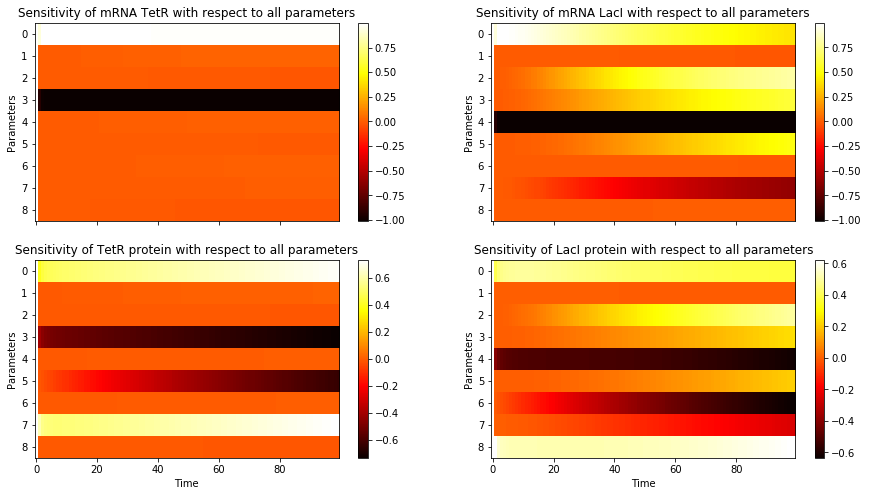

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, figsize = (15,8), sharex = 'col')
h00 = axs[0,0].imshow(SSM[:,:,0].T,cmap='hot', interpolation='nearest', aspect = 'auto')
fig.colorbar(h00, ax=axs[0,0])
axs[0,0].set_ylabel('Parameters')
axs[0,0].set_title('Sensitivity of mRNA TetR with respect to all parameters')
h01 = axs[0,1].imshow(SSM[:,:,1].T,cmap='hot', interpolation='nearest', aspect = 'auto')
fig.colorbar(h01, ax=axs[0,1])
axs[0,1].set_ylabel('Parameters')
axs[0,1].set_title('Sensitivity of mRNA LacI with respect to all parameters')
h10 = axs[1,0].imshow(SSM[:,:,2].T,cmap='hot', interpolation='nearest', aspect = 'auto')
fig.colorbar(h10, ax=axs[1,0])
axs[1,0].set_title('Sensitivity of TetR protein with respect to all parameters')
h11 = axs[1,1].imshow(SSM[:,:,3].T,cmap='hot', interpolation='nearest', aspect = 'auto')
fig.colorbar(h11, ax=axs[1,1])
axs[1,0].set_xlabel('Time')
axs[1,0].set_ylabel('Parameters')
axs[1,1].set_title('Sensitivity of LacI protein with respect to all parameters')
axs[1,1].set_ylabel('Parameters')
axs[1,1].set_xlabel('Time')

In [4]:
from sbml_to_ode2 import *
from scipy.integrate import odeint
import numpy as np
from sympy import *
from sympy.utilities.lambdify import lambdify
from sympy.abc import t

filename = "NAND_CRN.xml"

x_sym,f,P,params_values,x_init = sbml_to_ode2(filename)

param_eval_f = [None]*len(f)
i = 0
while i < len(f):
    param_eval_f[i] = f[i].subs(dict(zip(P,params_values)))
    i += 1


func = lambdify([t, x_sym, P], f)
func_p = lambdify([t, x_sym], param_eval_f)

n = len(x_sym)
timepoints = np.linspace(0,5000,1000)

ic = {"Sw1_OFF": 2000, "dna_A1": 2000, "rna_I1": 0, "Sw2_OFF": 2000, "dna_A2": 2000, "rna_I2": 0, "Sw3_OFF":2000, "dna_A31": 2000, "dna_A32": 2000, "protein_RNAseH":70,
      "protein_RNAP":500}
for i in ic.items():
    index = x_sym.index(Symbol(i[0]))
    x_init[index] = i[1]

solutions = odeint(lambda t, x: func_p(t,x), x_init, timepoints, tfirst = True)
solutions = np.reshape(solutions, (len(timepoints), n))



x_point = x_init
# Compute Jacobian at x_point
J = compute_J(lambda x, params_values: func(0, x, params_values), x_point, params_values)
#print(J)

# Compute sensitivity wrt 2nd parameter at x_point
Zj = compute_Zj(lambda x, params_values: func(0, x, params_values), x_point, 1, params_values) 
#print(Zj)

SSM = compute_SSM(func, solutions, params_values, timepoints, normalize = True)  
SSM = np.reshape(SSM, (len(timepoints), len(params_values), n))




/home/nazmus/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/nazmus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Sensitivity of Genelet-3-ON-2 with respect to all parameters')

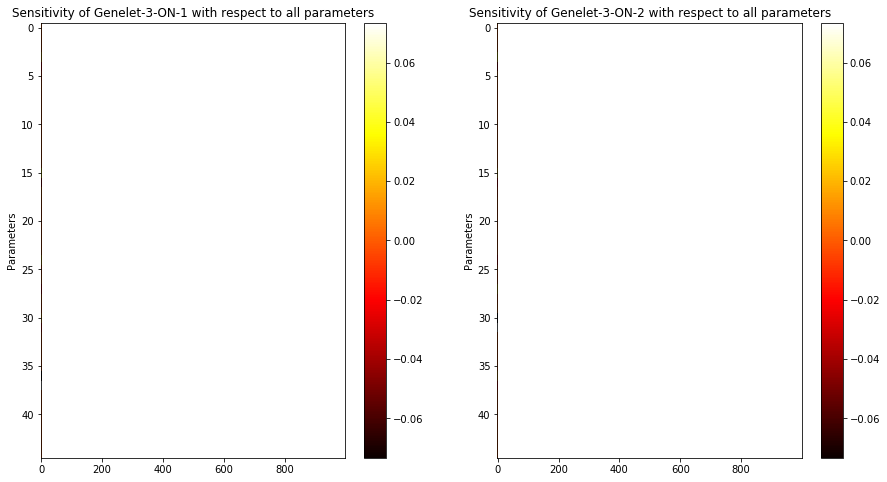

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize = (15,8), sharex = 'col')
h00 = axs[0].imshow(SSM[:,:,21].T,cmap='hot', interpolation='nearest', aspect = 'auto')
fig.colorbar(h00, ax=axs[0])
axs[0].set_ylabel('Parameters')
axs[0].set_title('Sensitivity of Genelet-3-ON-1 with respect to all parameters')
h01 = axs[1].imshow(SSM[:,:,22].T,cmap='hot', interpolation='nearest', aspect = 'auto')
fig.colorbar(h01, ax=axs[1])
axs[1].set_ylabel('Parameters')
axs[1].set_title('Sensitivity of Genelet-3-ON-2 with respect to all parameters')


In [14]:
len(params_values)
SSM.[shape]


(50, 45, 33)

In [18]:
21, 22

22

In [40]:
np.linspace?

Signature:
np.linspace(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
)
Docstring:
Return evenly spaced numbers over a specified interval.

Returns `num` evenly spaced samples, calculated over the
interval [`start`, `stop`].

The endpoint of the interval can optionally be excluded.

.. versionchanged:: 1.16.0
    Non-scalar `start` and `stop` are now supported.

Parameters
----------
start : array_like
    The starting value of the sequence.
stop : array_like
    The end value of the sequence, unless `endpoint` is set to False.
    In that case, the sequence consists of all but the last of ``num + 1``
    evenly spaced samples, so that `stop` is excluded.  Note that the step
    size changes when `endpoint` is False.
num : int, optional
    Number of samples to generate. Default is 50. Must be non-negative.
endpoint : bool, optional
    If True, `stop` is the last sample. Otherwise, it is not included.
    Default is True.
retstep : 

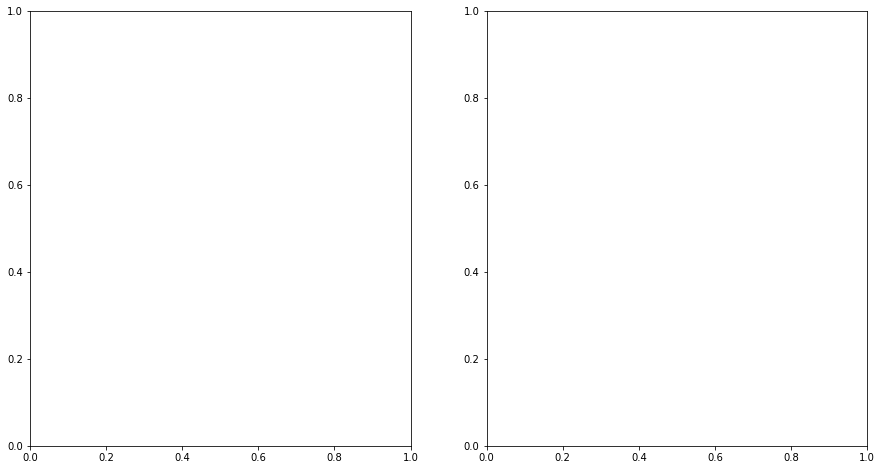